Inspired by https://www.kaggle.com/code/adaubas/tps-jul22-lgbm-extratree-qda-soft-voting/notebook, following notebook fits classifier using Sklearn.

In [10]:
import pandas as pd
import numpy as np

import gc,os

from sklearn.preprocessing import PowerTransformer,RobustScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.ensemble import VotingClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 

from sklearn.neural_network import MLPClassifier


import warnings
warnings.filterwarnings('ignore')

In [2]:
random_state = 0
n_folds = 10
n_components = 7
verbose = 500
os.environ['PYTHONHASHSEED'] = str(random_state)
np.random.seed(random_state)

In [4]:
!kaggle competitions download -c tabular-playground-series-jul-2022
!unzip tabular-playground-series-jul-2022
!rm tabular-playground-series-jul-2022

tabular-playground-series-jul-2022.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  tabular-playground-series-jul-2022.zip
  inflating: data.csv                
  inflating: sample_submission.csv   
rm: tabular-playground-series-jul-2022: No such file or directory


In [3]:
data = pd.read_csv("data.csv",index_col = 'id')
sample_submission =pd.read_csv("sample_submission.csv")

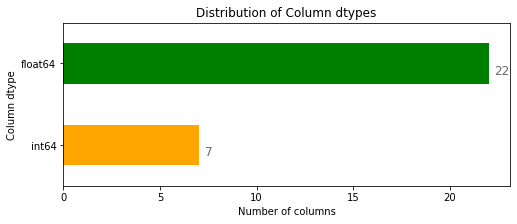

In [4]:
ax = data.dtypes.value_counts().plot.barh(color = ['green','orange'],rot = 0,figsize = (8,3))
ax.set_title('Distribution of Column dtypes')
ax.set_xlabel('Number of columns')
ax.set_ylabel('Column dtype')

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, str(i.get_width()), fontsize=12,
color='dimgrey')
    
ax.invert_yaxis()

In [5]:
# Using PowerTransformer before Scaling to adjust for Outliers
data_scaled = pd.DataFrame(PowerTransformer().fit_transform(data),columns=data.columns)
#data_scaled = pd.DataFrame(RobustScaler().fit_transform(data_scaled), columns=data_scaled.columns)

#www.kaggle.com/competitions/tabular-playground-series-jul-2022/discussion/334808
useful_cols  = ['f_07','f_08', 'f_09', 'f_10','f_11', 'f_12', 'f_13', 'f_22','f_23', 'f_24', 'f_25','f_26','f_27', 'f_28']

# Test Data for predictions later
test_data = data_scaled[useful_cols].copy()

In [6]:
# Fit Bayesian Gaussian Mixture
print('Fitting Bayesian Gaussian Mixture..')
bgm = BayesianGaussianMixture(n_components = n_components,
                         max_iter = 300, n_init = 10, 
                     random_state = random_state,
                 verbose = 1,
             verbose_interval = 100
                     )

bgm_labels = bgm.fit_predict(data_scaled[useful_cols])
bgm_proba = bgm.predict_proba(data_scaled[useful_cols])

Fitting Bayesian Gaussian Mixture..
Initialization 0
  Iteration 100
Initialization converged: True
Initialization 1
Initialization converged: True
Initialization 2
Initialization converged: True
Initialization 3
  Iteration 100
Initialization converged: True
Initialization 4
  Iteration 100
  Iteration 200
Initialization converged: True
Initialization 5
  Iteration 100
  Iteration 200
Initialization converged: True
Initialization 6
Initialization converged: True
Initialization 7
Initialization converged: True
Initialization 8
Initialization converged: True
Initialization 9
Initialization converged: True


In [7]:
#Using idea from https://www.kaggle.com/code/adaubas/tps-jul22-lgbm-extratree-qda-soft-voting

# Creating Best data based on predicted probability of BGM model

data_scaled['predict']= bgm_labels
data_scaled['predict_proba']=0

for n in range(n_components):
    data_scaled[f'bgm_proba_{n}']= bgm_proba[:,n]
    data_scaled.loc[data_scaled.predict == n,'bgm_proba']=data_scaled[f'bgm_proba_{n}']
    
train_index=np.array([])
for n in range(n_components):
    median=data_scaled[data_scaled.predict==n]['bgm_proba'].median()

    # Experiment with different thresholds
    # Higher thereshold might overfit
    n_inx=data_scaled[(data_scaled.predict==n) & (data_scaled.bgm_proba > 0.9)].index
    
    train_index = np.concatenate((train_index, n_inx))
    print(f'class:{n}',f'median: {round(median,4)}','Training data:'+str(round(len(n_inx)/len(data_scaled[(data_scaled.predict==n)]),2)*100)+'%')
    
    
print(f'\nSize of Training data : {len(train_index)}')

class:0 median: 0.9074 Training data:51.0%
class:1 median: 0.8685 Training data:44.0%
class:2 median: 0.9376 Training data:56.99999999999999%
class:3 median: 0.7311 Training data:25.0%
class:4 median: 0.8669 Training data:44.0%
class:5 median: 0.9833 Training data:73.0%
class:6 median: 0.9118 Training data:52.0%

Size of Training data : 48674


In [15]:
X=data_scaled.loc[train_index][useful_cols].to_numpy()
y=data_scaled.loc[train_index]['predict'].to_numpy()
#xtrain,xvalid, ytrain,yvalid = train_test_split(X,y,random_state = random_state,test_size = 0.2)

In [21]:
# Define parameter for the GradientBoostingClassifier for hyperparameter tuning.
gbc_praman_grid = { 'subsample' : np.linspace(0.1, 1.0, 10, endpoint=True),
'max_depth' : np.linspace(1, 15, 15, endpoint=True),
'criterion' :  ['friedman_mse', 'mse'],
'min_sample_split' : np.linspace(2, 100, 50, endpoint=True),
'min_impurity_decrease' : np.linspace(0.0, 1.0, 10, endpoint=True),
}

gbc = GradientBoostingClassifier(n_estimators = 5000,
                        random_state=random_state,
                     max_features = 'auto',
                    validation_fraction =0.2,
                    n_iter_no_change = 300,
                    verbose = 1
                    )

gbc_search = HalvingGridSearchCV(gbc,gbc_praman_grid,resource='n_estimators',max_resources=5000, random_state=random_state,cv=10,verbose= 1).fit(X,y)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 61
max_resources_: 5000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 150
n_resources: 61
Fitting 10 folds for each of 150 candidates, totalling 1500 fits
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.7888           0.1222            7.99s
         2           1.6930           0.0970            7.51s
         3           1.6203           0.0774            7.04s
         4           1.5427           0.0699            6.73s
         5           1.4843           0.0617            6.37s
         6           1.4234           0.0553            6.12s
         7           1.3758           0.0478            5.95s
         8           1.3319           0.0437            5.80s
         9           1.2945           0.0417            5.63s
        10           1.2653           0.0348            5.55s
        20           0.9886           0.0222         

In [16]:
# Create parameter grid
parameter_grid = {'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
                  'max_depth' : np.linspace(1, 15, 15, endpoint=True),
                  'max_leaf_nodes': [10,30,35,40,45,55,60],
                  'min_samples_leaf': np.linspace(10, 100, 10, endpoint=True),
                  'l2_regularization': np.linspace(0.0, 1.0, 10, endpoint=True),
                  "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
                  }

# Create and fit classifier

hgbc = HistGradientBoostingClassifier(max_iter = 1000,
                                      random_state=random_state,
                    validation_fraction =0.2,
                    n_iter_no_change = 300,
                    verbose = 1000
)

# Create grid search
# Create GridSearchCV object
halving_grid_search = HalvingGridSearchCV(hgbc, parameter_grid, cv=5, scoring='roc_auc',n_jobs= -1)
halving_grid_search.fit(X, y)


# Print results
print(halving_grid_search.best_score_)
print(halving_grid_search.best_params_)


In [23]:
gc.collect()
# XG Boost can also be used
gbc = GradientBoostingClassifier(n_estimators = 3000,
                        subsample = 0.6,
                        random_state=random_state,
                     max_features = 'auto',
                    validation_fraction =0.2,
                    n_iter_no_change = 200,
                    max_depth = 12,
                    verbose = 1
                    )

# This is inspired by LGBM. LGBM can also be used directly
hgbc = HistGradientBoostingClassifier(max_iter = 5000,
                                      learning_rate = 0.06,
                                      random_state=random_state,
                    validation_fraction =0.2,
                    n_iter_no_change = 200,
                    l2_regularization=0.1,
                    verbose = 1000
)

# Saving time by using ML classifier. Can experiment with Torch/Keras based NN models as well
mlpc = MLPClassifier(learning_rate = 'adaptive',
                    max_iter = 5000,
                    hidden_layer_sizes = (400,200,100,),
                    early_stopping = True,
                    n_iter_no_change = 200,
                    validation_fraction = 0.2,
                    )

qda = QuadraticDiscriminantAnalysis()

gpc = GaussianProcessClassifier(max_iter_predict=1000, random_state  =random_state)

# This is simplified version of soft voting as suggested by 
# https://www.kaggle.com/code/pourchot/simple-soft-voting?scriptVersionId=100462375&cellId=6
vcsft = VotingClassifier(estimators=[('GBC', gbc), ('HGBC', hgbc),('MLPC',mlpc),('QDA',qda),('GPC',gpc)], 
                 voting='soft',verbose=verbose)

In [24]:
vcsft.fit(X,y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3578           0.4696           86.47m
         2           1.0824           0.2615           93.44m
         3           0.8828           0.1863           94.28m
         4           0.7308           0.1407           95.62m
         5           0.6109           0.1099           96.03m
         6           0.5139           0.0882           96.91m
         7           0.4356           0.0725           97.94m
         8           0.3682           0.0593           97.54m
         9           0.3142           0.0498           97.66m
        10           0.2682           0.0411           97.40m
        20           0.0609           0.0080           97.44m
        30           0.0159           0.0017           94.93m
        40           0.0048           0.0004           91.02m
        50           0.0017           0.0001           88.41m
        60           0.0006           0.0000           86.55m
       

: 

: 

In [ ]:
Predicted = vcsft.predict(test_data.to_numpy())

In [ ]:
sample_submission['Predicted']= Predicted
sample_submission.to_csv("submission.csv",index=False)
sample_submission.head()

,Id,Predicted
0,0,4
1,1,6
2,2,4
3,3,2
4,4,3


In [ ]:
!kaggle competitions submit -c tabular-playground-series-jul-2022 -f submission.csv -m "Soft Voting using Sklearn part 2"

100%|█████████████████████████████████████████| 755k/755k [00:01<00:00, 521kB/s]
Successfully submitted to Tabular Playground Series - Jul 2022